## 2.1 - Exploratory Data Analysis (EDA)

### Libraries and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display

In [2]:
path = "D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_raw.parquet"
raw_reviews = pd.read_parquet(path, engine="pyarrow") 

### 2.1.1 - Analysis of Variable Distributions

In [9]:
print(f"raw_reviews shape: {raw_reviews.shape}")
display(raw_reviews.head(3))

raw_reviews shape: (826905, 11)


,app_name,app_id,reviewId,user_name,score,text,date,thumbs_up,Reply,Reply_Date,App_Version
0,Santander,uk.co.santander.santanderUK,ee79d039-dd5b-468c-a5f0-f231ba1a7151,A Google user,4,What is the policy in regard to root/custom ROMs?,2025-12-09 03:08:56+00:00,0,None,NaT,5.29.0
1,Santander,uk.co.santander.santanderUK,cbd0ae2c-ca44-4478-ab3a-88f962419372,A Google user,1,Depositing a cheque most difficult thing to do...,2025-12-08 23:44:12+00:00,0,None,NaT,5.29.0
2,Santander,uk.co.santander.santanderUK,942e1e38-b899-469f-b602-70c2f974e60b,A Google user,4,The new widget to dispay the balance on the sc...,2025-12-08 19:36:37+00:00,0,None,NaT,5.29.0


First, the distributions of the variables were examined to understand the information contained within the DataFrame.

In [10]:
reviews = raw_reviews.copy()

### Total Reviews and Average Score per App (`app_name` and `score`)

In [11]:
cols = ['app_name', 'score']

for col in cols:
    print(reviews[col].value_counts())
    print("-----------------------------------")

app_name
Barclays     268074
Revolut      265788
Lloyds       150762
Santander     80171
HSBC          39524
Monzo         22586
Name: count, dtype: int64
-----------------------------------
score
5    601457
1    100742
4     76960
3     25800
2     21946
Name: count, dtype: int64
-----------------------------------


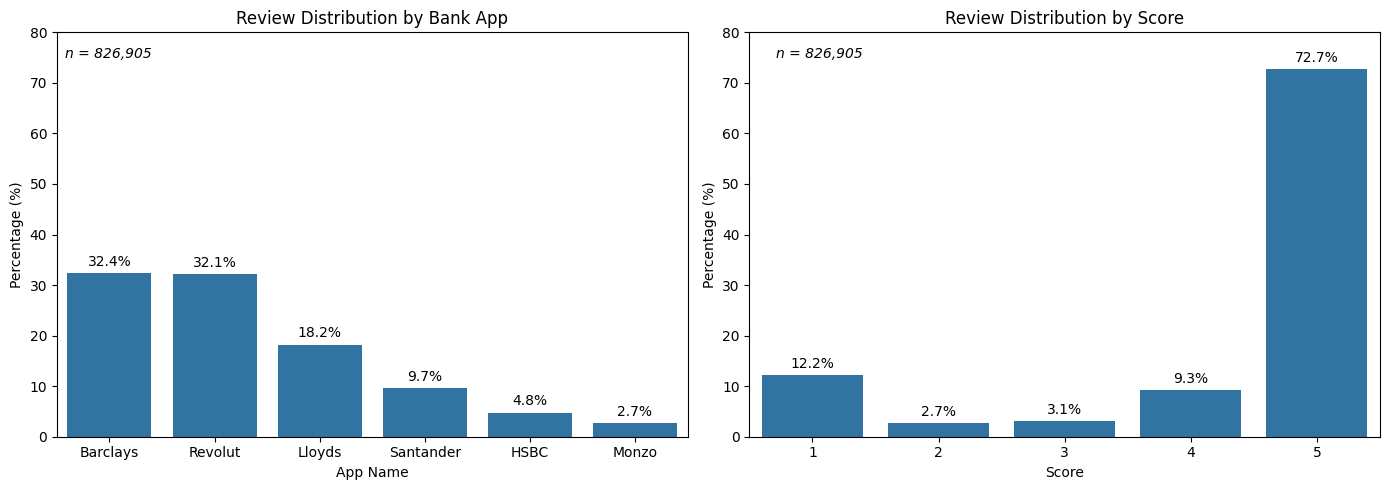

In [12]:
# Reusing earlier setup...
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute percentage distributions
app_pct = (reviews['app_name'].value_counts(normalize=True) * 100).reset_index()
app_pct.columns = ['app_name', 'percentage']

score_pct = (reviews['score'].value_counts(normalize=True) * 100).sort_index().reset_index()
score_pct.columns = ['score', 'percentage']

# Plot 1: App Name
sns.barplot(data=app_pct, x='app_name', y='percentage', ax=axes[0])
axes[0].set_title('Review Distribution by Bank App')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xlabel('App Name')
axes[0].set_ylim(0, 80)
axes[0].set_yticks(range(0, 81, 10))
axes[0].bar_label(axes[0].containers[0], fmt='%.1f%%', label_type='edge', padding=3)

# Add total observation count
total_app = reviews['app_name'].notna().sum()
axes[0].annotate(f'n = {total_app:,}', xy=(0.4, 75), ha='right', fontsize=10, fontstyle='italic')

# Plot 2: Score
sns.barplot(data=score_pct, x='score', y='percentage', ax=axes[1])
axes[1].set_title('Review Distribution by Score')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Score')
axes[1].set_ylim(0, 80)
axes[1].set_yticks(range(0, 81, 10))
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%', label_type='edge', padding=3)

# Add total observation count
total_score = reviews['score'].notna().sum()
axes[1].annotate(f'n = {total_score:,}', xy=(0.4, 75), ha='right', fontsize=10, fontstyle='italic')

plt.tight_layout()
plt.show()

**Number of Reviews:** Barclays and Revolut account for a significant proportion of the total reviews. Nevertheless, even the bank with the fewest reviews (i.e., Monzo) still has over 22,500 reviews, providing sufficient data to extract meaningful insights for each bank.

**Score:** A predominance of 5-star scores is observed, followed by 1-star scores. This suggests that reviews are generally submitted by customers in extreme situations, either highly positive or highly negative.

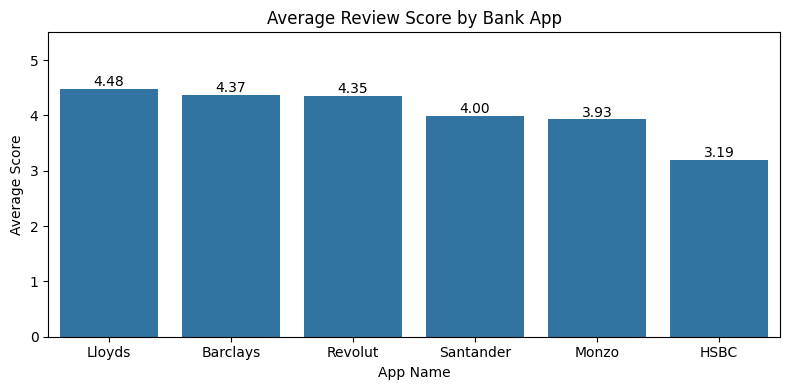

In [13]:
# Calculate average score per app
avg_score = (
    reviews.groupby('app_name')['score']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=avg_score, x='app_name', y='score')

# Add value labels
for index, row in avg_score.iterrows():
    plt.text(x=index, y=row['score'] + 0.05, s=f"{row['score']:.2f}", ha='center', fontsize=10)

# Style
plt.title('Average Review Score by Bank App')
plt.xlabel('App Name')
plt.ylabel('Average Score')
plt.ylim(0, 5.5)
plt.yticks([0, 1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

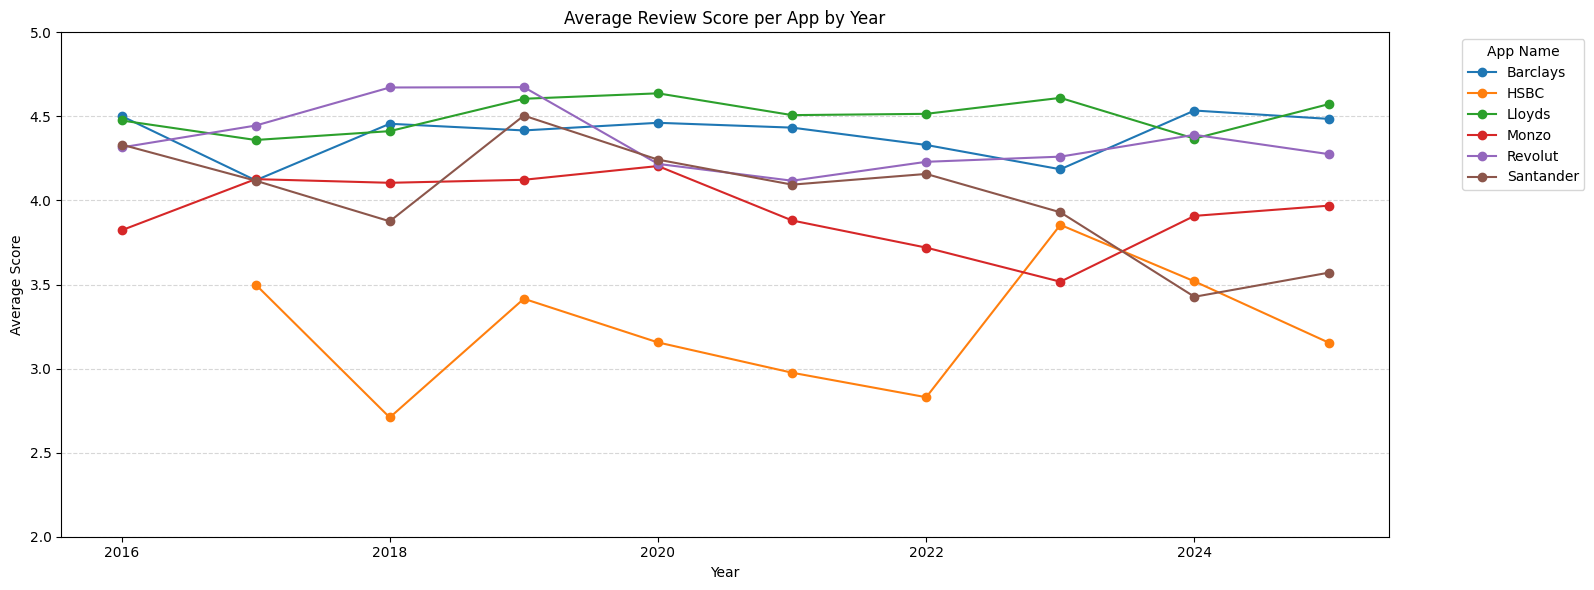

In [14]:
# Convert 'date' to datetime
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

# Group by year and app_name, then calculate mean score
reviews['year'] = reviews['date'].dt.year
score_by_year_app = reviews.groupby(['year', 'app_name'])['score'].mean().reset_index()

# Filter to keep only years from 2016 onward
filtered_scores = score_by_year_app[score_by_year_app['year'] >= 2016]

# Pivot for plotting (years as x, apps as separate lines)
pivot_df = filtered_scores.pivot(index='year', columns='app_name', values='score')

# Plot
pivot_df.plot(marker='o', figsize=(16, 6))
plt.title('Average Review Score per App by Year')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.ylim(2, 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='App Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 2.1.2 - Review Engagement Analysis

### Thumbs-Up Counts per Review (`thumbs_up`)

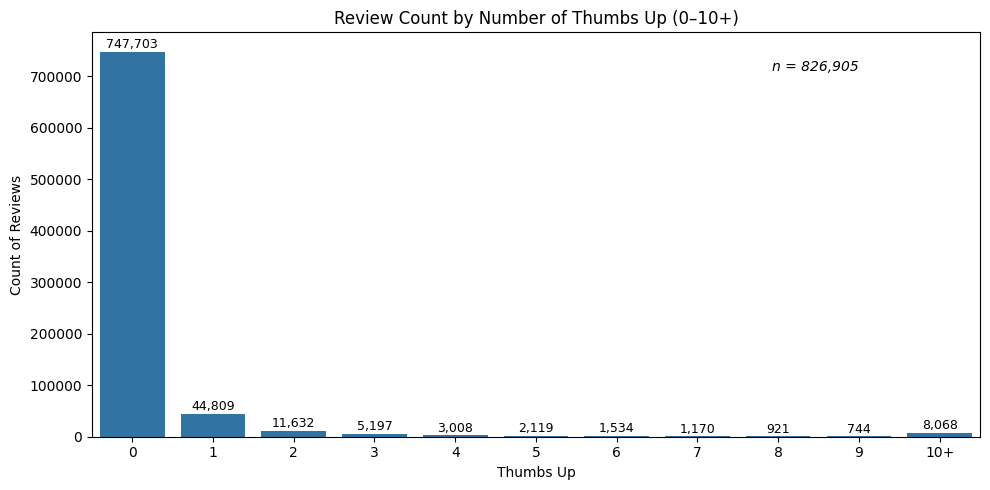

In [15]:
# Prepare thumbs_up count data
thumbs_counts_raw = reviews['thumbs_up'].value_counts().sort_index()

# Aggregate values >=10 into a "10+" bucket
thumbs_buckets = thumbs_counts_raw[thumbs_counts_raw.index <= 9].copy()
thumbs_buckets.loc[10] = thumbs_counts_raw[thumbs_counts_raw.index >= 10].sum()

# Convert to DataFrame
thumbs_counts = thumbs_buckets.reset_index()
thumbs_counts.columns = ['thumbs_up', 'count']

# Replace 10 with '10+'
thumbs_counts['thumbs_up'] = thumbs_counts['thumbs_up'].apply(lambda x: '10+' if x == 10 else str(x))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=thumbs_counts, x='thumbs_up', y='count')

# Add count labels
for index, row in thumbs_counts.iterrows():
    plt.text(x=index, y=row['count'] + 7000, s=f"{row['count']:,}", ha='center', fontsize=9)

# Add total observation count
total_thumbs_up = raw_reviews['thumbs_up'].notna().sum()
plt.annotate(f'n = {total_thumbs_up:,}', xy=(9, 710000), ha='right', fontsize=10, fontstyle='italic')

# Style
plt.title('Review Count by Number of Thumbs Up (0–10+)')
plt.xlabel('Thumbs Up')
plt.ylabel('Count of Reviews')
plt.tight_layout()
plt.show()

**Thumbs-Up Distribution:** Approximately 90% of the reviews did not receive any thumbs-up (i.e., 'likes').

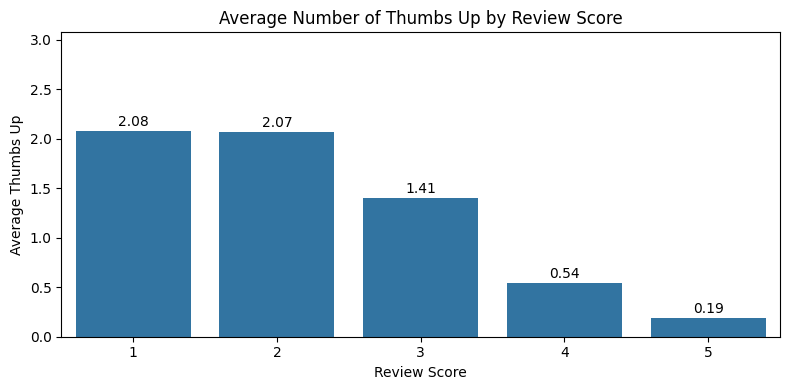

In [16]:
# Calculate average thumbs_up per score
avg_thumbs_by_score = (
    reviews.groupby('score')['thumbs_up']
    .mean()
    .reset_index()
    .sort_values('score')
)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=avg_thumbs_by_score, x='score', y='thumbs_up')

# Add value labels
for index, row in avg_thumbs_by_score.iterrows():
    plt.text(x=index, y=row['thumbs_up'] + 0.05, s=f"{row['thumbs_up']:.2f}", ha='center', fontsize=10)

# Style
plt.title('Average Number of Thumbs Up by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Average Thumbs Up')
plt.ylim(0, avg_thumbs_by_score['thumbs_up'].max() + 1)

plt.tight_layout()
plt.show()

### Average Thumbs-Up per Score

Although the majority of reviews have a score of 5 and receive zero thumbs-up, the analysis reveals a clear inverse relationship: **reviews with lower scores (1–2) receive significantly more thumbs-up on average than reviews with higher scores**.

**Key Findings:**
- Score 1 reviews: 2.08 average thumbs-up  
- Score 2 reviews: 2.07 average thumbs-up  
- Score 3 reviews: 1.41 average thumbs-up  
- Score 4 reviews: 0.54 average thumbs-up  
- Score 5 reviews: 0.19 average thumbs-up  

This corresponds to an approximate **10× difference** in engagement between the most critical (score 1) and most positive (score 5) reviews, indicating that negative reviews are perceived as more helpful or informative by readers.

### Review Dates (`date`)

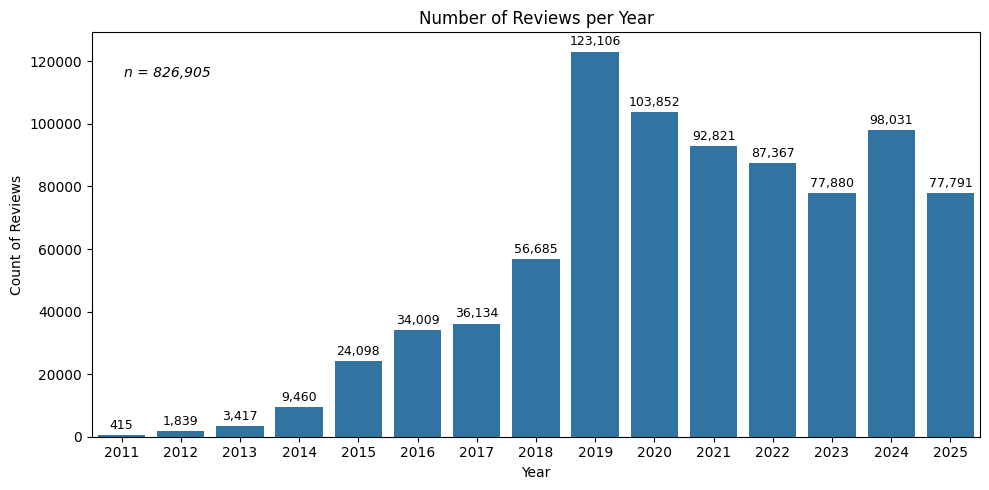

In [17]:
# Count number of reviews per year
reviews_by_year = (
    reviews['year']
    .value_counts()
    .sort_index()
    .reset_index()
)
reviews_by_year.columns = ['year', 'count']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=reviews_by_year, x='year', y='count')

# Add value labels
for index, row in reviews_by_year.iterrows():
    plt.text(x=index, y=row['count'] + 2000, s=f"{row['count']:,}", ha='center', fontsize=9)

# Add total observation count
total_date = reviews['date'].notna().sum()
plt.annotate(f'n = {total_date:,}', xy=(1.5, 115000), ha='right', fontsize=10, fontstyle='italic')

# Style
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.tight_layout()
plt.show()

### Review Volume Over Time

The dataset shows **exponential growth from 2011-2019**, peaking at 123,106 reviews in 2019. Following the peak, there's a **gradual decline through 2023** (77,880 reviews), with a notable **rebound in 2024** (98,031 reviews) before dropping again in 2025 (77,791 reviews, partial year data).

In [19]:
last_review = reviews['date'].max()
print(f"Date of the last review existent in the dataframe: {last_review}")

Date of the last review existent in the dataframe: 2025-12-09 03:46:08+00:00


⚠️ **Note:** These values may not fully reflect user activity, but rather data availability. In some cases, APIs or scrapers capture recent reviews more reliably than older ones.

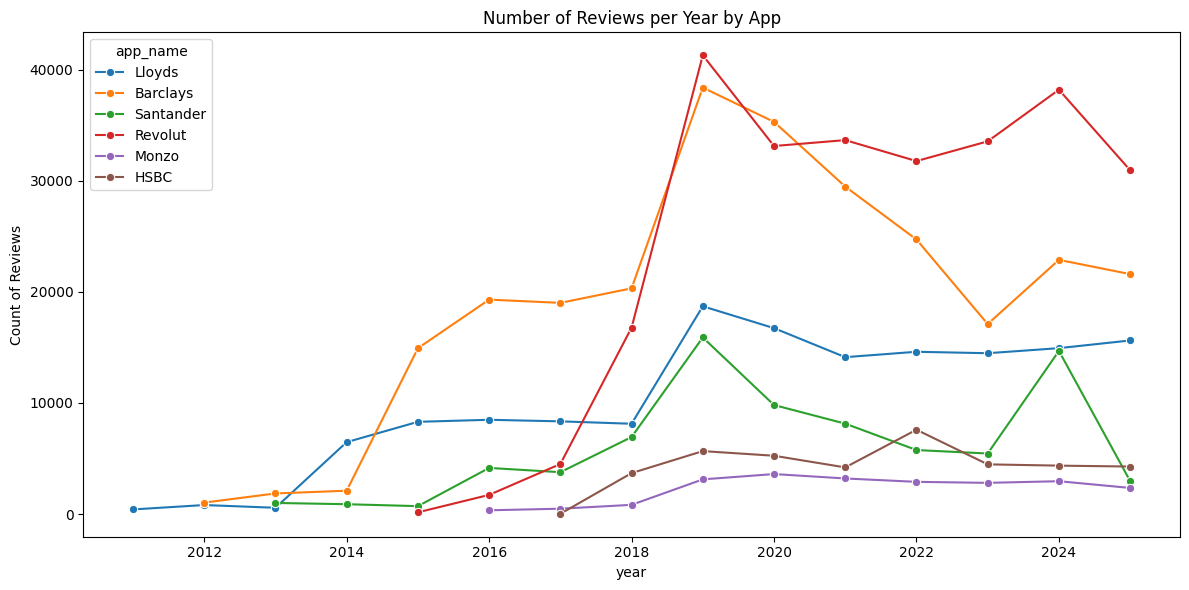

In [20]:
reviews_by_year_app = reviews.groupby(['year', 'app_name']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=reviews_by_year_app, x='year', y='count', hue='app_name', marker='o')
plt.title('Number of Reviews per Year by App')
plt.ylabel('Count of Reviews')
plt.tight_layout()
plt.show()

### Review Trends by App

While some differences exist across banking apps, the **overall trend is relatively consistent across players**. Most apps show a **strong surge in reviews around 2019** (with Revolut experiencing a particularly dramatic spike to 41,000+ reviews), followed by a **gradual decline through 2023**. A **modest rebound occurred in 2024**, though review volumes remain below 2019 peak levels for most apps.

**Notable patterns:**
- **Revolut and Barclays** dominated review volume during the 2019 peak (~41K and ~38K respectively)
- **Traditional banks** (Lloyds, Barclays, HSBC) show more stable trajectories
- **Digital-first apps** (Revolut, Monzo) exhibit more volatile patterns
- **Santander** shows an unusual spike in 2024, bucking the general trend

### Replies (`Reply` and `Reply_Date`)

In [21]:
print(f"Number of reviews with reply: {reviews['Reply'].notna().sum()}")
print("----------------------------------------")
print(f"Number of reviews without reply: {reviews['Reply'].isna().sum()}")

Number of reviews with reply: 114788
----------------------------------------
Number of reviews without reply: 712117


In [22]:
reviews['Replied'] = reviews['Reply'].notna().astype('int8')
reviews.head(3)

,app_name,app_id,reviewId,user_name,score,text,date,thumbs_up,Reply,Reply_Date,App_Version,year,Replied
0,Santander,uk.co.santander.santanderUK,ee79d039-dd5b-468c-a5f0-f231ba1a7151,A Google user,4,What is the policy in regard to root/custom ROMs?,2025-12-09 03:08:56+00:00,0,None,NaT,5.29.0,2025,0
1,Santander,uk.co.santander.santanderUK,cbd0ae2c-ca44-4478-ab3a-88f962419372,A Google user,1,Depositing a cheque most difficult thing to do...,2025-12-08 23:44:12+00:00,0,None,NaT,5.29.0,2025,0
2,Santander,uk.co.santander.santanderUK,942e1e38-b899-469f-b602-70c2f974e60b,A Google user,4,The new widget to dispay the balance on the sc...,2025-12-08 19:36:37+00:00,0,None,NaT,5.29.0,2025,0


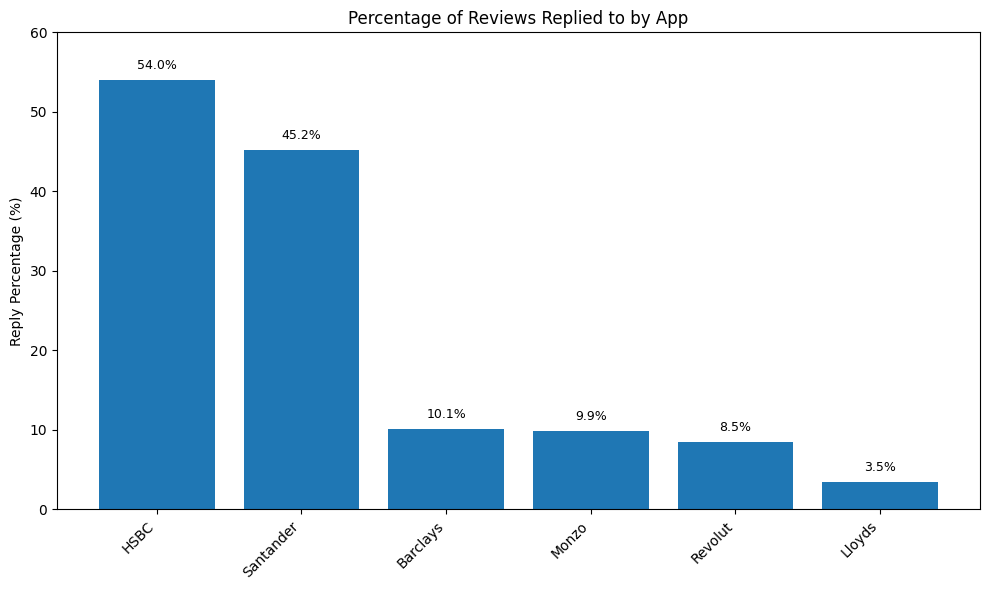

In [23]:
# Group by app and calculate reply stats
reply_stats = reviews.groupby('app_name').agg(
    total_reviews=('Replied', 'count'),
    replied_reviews=('Replied', 'sum')
)

# Compute reply percentage
reply_stats['reply_percentage'] = (reply_stats['replied_reviews'] / reply_stats['total_reviews']) * 100

# Sort by reply percentage
reply_stats = reply_stats.sort_values(by='reply_percentage', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(reply_stats.index, reply_stats['reply_percentage'])

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # slightly above the bar
        f'{height:.1f}%',  # format to 1 decimal place
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.ylabel('Reply Percentage (%)')
plt.ylim(0, 60)
plt.title('Percentage of Reviews Replied to by App')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Customer Engagement: Reply Rates by App

There is **substantial variation** in how banks engage with customer reviews. **Traditional banks HSBC (54.0%) and Santander (45.2%) actively respond to reviews**, while **digital-first banks show minimal engagement**, with Barclays (10.1%), Monzo (9.9%), and Revolut (8.5%) replying to roughly 1 in 10 reviews. Lloyds has the lowest reply rate at just 3.5%.

The `time_to_reply_hours` was analyzed in cases where a reply was provided, by calculating the difference between `date` and `Reply_Date` and converting it into hours.

In [24]:
# Remove timezone from 'date'
reviews['date'] = reviews['date'].dt.tz_localize(None)

# Calculate time to reply in hours
reviews['Reply_Date'] = pd.to_datetime(reviews['Reply_Date'])
reviews['time_to_reply'] = reviews['Reply_Date']-reviews['date']
reviews['time_to_reply_hours'] = (reviews['time_to_reply'].dt.total_seconds() / 3600).round(2) # convert seconds to hours (60 * 60)
reviews.drop('time_to_reply', axis=1, inplace=True)

Since some reviews have a `Reply_Date` earlier than the review `date`, which is logically inconsistent, these cases were removed prior to analyzing reply times. Such abnormal dates may result from inconsistent or erroneous timestamps.

In [25]:
no_error_date = reviews[reviews['time_to_reply_hours']>0]
print(no_error_date.shape)

(104302, 14)


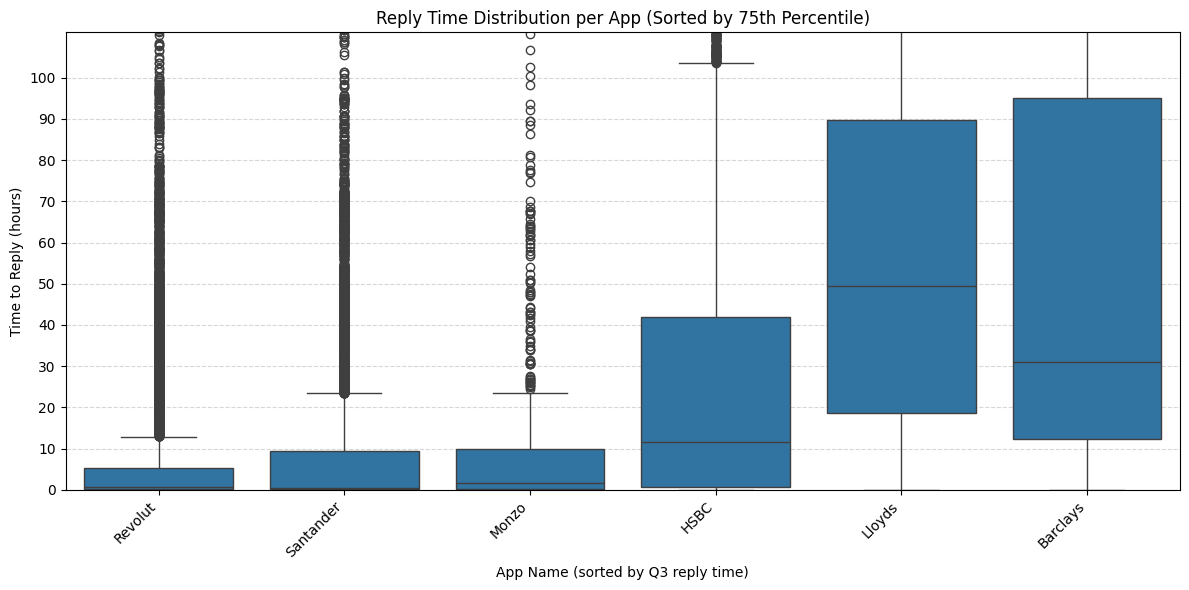

In [26]:
# Filter for valid replies
replied_reviews = no_error_date[no_error_date['Replied'] == 1]

# Calculate Q3 (75th percentile) per app
q3_per_app = (
    replied_reviews
    .groupby('app_name')['time_to_reply_hours']
    .quantile(0.75)
    .sort_values()
)

# Reorder the 'app_name' column based on Q3
replied_reviews['app_name'] = pd.Categorical(
    replied_reviews['app_name'],
    categories=q3_per_app.index,
    ordered=True
)

# Plot the boxplot with custom app order
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=replied_reviews,
    x='app_name',
    y='time_to_reply_hours',
    showfliers=True
)
plt.xlabel('App Name (sorted by Q3 reply time)')
plt.ylabel('Time to Reply (hours)')
plt.title('Reply Time Distribution per App (Sorted by 75th Percentile)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 111)
plt.yticks(range(0, 110, 10))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Response Time Performance by App

While HSBC leads in reply rate, **Revolut, Santander, and Monzo excel in response speed**. These three apps reply to 75% of reviews within **~10 hours**, demonstrating highly responsive customer service. In contrast, HSBC's 75th percentile reply time is **~45 hours**, while **Barclays and Lloyds lag significantly at 90+ hours**.

**Key insight:** High reply rates don't guarantee fast responses—HSBC replies frequently but slowly, while digital-first banks (Revolut, Monzo) prioritize speed over volume.

### User Name (`user_name`)

It was observed that many `user_name` values are listed as 'A Google user'. The percentage of rows with identifiable users was calculated to assess the potential value of this column for analysis.

In [27]:
no_user = ((reviews['user_name'] == 'A Google user').sum()) / len(reviews) * 100
print(f"Percentage of rows without User information: {no_user:.2f}%")

Percentage of rows without User information: 99.78%


Fewer than 1% of the reviews contain an identifiable username, rendering this information largely irrelevant for the purposes of this project. Consequently, the `user_name` column will be dropped from the dataset.

### App Versions (`app_version`)

The number of unique `App_Version` entries was analyzed for each bank to understand the diversity of app versions present in the dataset.

In [28]:
print(reviews.groupby('app_name')['App_Version'].nunique())
print(reviews.groupby('app_name')['App_Version'].nunique().sum())

app_name
Barclays     197
HSBC         107
Lloyds       184
Monzo        491
Revolut      770
Santander    104
Name: App_Version, dtype: int64
1853


A substantial number of distinct app versions were observed during the period of analysis, ranging from **104 versions for Santander UK** to **770 versions for Revolut**. Overall, **1,853 unique app versions** were recorded across all six banks, highlighting frequent updates and version diversity.

In [29]:
# Split 'App_Version' into two parts: before and after the first dot
version_split = reviews['App_Version'].astype(str).str.split('.', n=1, expand=True)

# Assign to new columns
reviews['version_macro'] = version_split[0]
reviews['version_detail'] = version_split[1]

# If there's no dot, move the value to 'version_detail' and set 'version_macro' as NaN
mask_no_dot = ~reviews['App_Version'].astype(str).str.contains('.')
reviews.loc[mask_no_dot, 'version_macro'] = pd.NA
reviews.loc[mask_no_dot, 'version_detail'] = reviews.loc[mask_no_dot, 'App_Version']

In [30]:
print(reviews.groupby('app_name')['version_macro'].nunique())
print(reviews.groupby('app_name')['version_macro'].nunique().sum())

app_name
Barclays       4
HSBC           3
Lloyds       146
Monzo          9
Revolut       11
Santander      6
Name: version_macro, dtype: int64
179


Using a refined approach to analyze app versions, a significant reduction in the number of macro versions was observed for most banks, with the exception of Lloyds, which appears to use a different app version categorization format.

⚠️ Further cleaning of the `App_Version` data for Lloyds could be performed; however, it will be retained in its current form for now and only revisited if a specific use case requires detailed app version analysis.

To facilitate this analysis, the `App_Version` column was split into two components: `version_macro` (the portion before the first dot) and `version_detail` (the portion after the first dot). For app versions without a dot, the entire value was assigned to `version_detail` and `version_macro` was set as missing (NaN).

The resulting number of unique macro versions per app is as follows:

- **Barclays:** 4  
- **HSBC:** 3  
- **Lloyds:** 146  
- **Monzo:** 9  
- **Revolut:** 11  
- **Santander:** 6  

In total, **179 unique macro versions** were identified across all six banks.

## 2.2 - Data Cleaning

A cleaned DataFrame will be created using the `cleaning` function, which encapsulates all preprocessing steps identified in this notebook. This prepares the dataset for subsequent sentiment analysis and topic modeling.

In [31]:
raw_reviews.shape

(826905, 11)

In [32]:
raw_reviews.head(2)

,app_name,app_id,reviewId,user_name,score,text,date,thumbs_up,Reply,Reply_Date,App_Version
0,Santander,uk.co.santander.santanderUK,ee79d039-dd5b-468c-a5f0-f231ba1a7151,A Google user,4,What is the policy in regard to root/custom ROMs?,2025-12-09 03:08:56+00:00,0,None,NaT,5.29.0
1,Santander,uk.co.santander.santanderUK,cbd0ae2c-ca44-4478-ab3a-88f962419372,A Google user,1,Depositing a cheque most difficult thing to do...,2025-12-08 23:44:12+00:00,0,None,NaT,5.29.0


In [33]:
print(raw_reviews['app_id'].value_counts())

app_id
com.barclays.android.barclaysmobilebanking    268074
com.revolut.revolut                           265788
com.grppl.android.shell.CMBlloydsTSB73        150762
uk.co.santander.santanderUK                    80171
uk.co.hsbc.hsbcukmobilebanking                 39524
co.uk.getmondo                                 22586
Name: count, dtype: int64


In [34]:
def cleaning(input_path="D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_raw.parquet",
             output_path="D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_clean.parquet"):
    """
    Load raw review data, apply cleaning transformations, and save cleaned dataset.
    Removes reviews prior to 2019-01-01.
    """
    df = pd.read_parquet(input_path)

    # Remove unused columns
    df = df.drop(columns=['user_name', 'app_id', 'reviewId'])
    
    # Create sequential ID column
    df.insert(0, 'ID', np.arange(1, 1 + len(df), dtype='int32'))

    # Convert date columns to datetime
    for c in ['date', 'Reply_Date']:
        df[c] = pd.to_datetime(df[c], errors='coerce')
    
    # Extract year from review date
    df['year'] = df['date'].dt.year.astype('Int16')
    
    # Create binary replied indicator
    df['replied'] = df['Reply'].notna().astype('int8')
    
    # Calculate time to reply in hours
    df['date'] = df['date'].dt.tz_localize(None)
    delta = df['Reply_Date'] - df['date']
    df['time_to_reply(h)'] = (delta.dt.total_seconds() / 3600).round(2)
    
    # Split app version into major and minor components
    vs = df['App_Version'].astype(str).str.split('.', n=1, expand=True)
    df['app_version_head'] = vs[0]
    df['app_version_detail'] = vs[1]
    
    # Handle versions without dot separator
    no_dot = ~df['App_Version'].astype(str).str.contains('.', regex=False)
    df.loc[no_dot, 'app_version_head'] = pd.NA
    df.loc[no_dot, 'app_version_detail'] = df.loc[no_dot, 'App_Version']
    df = df.drop(columns=['App_Version'])
    
    # Standardize column names
    colmap = {
        'app_name': 'app',
        'text': 'review_text',
        'date': 'review_date',
        'Reply': 'reply_text',
        'Reply_Date': 'reply_date',
    }
    df = df.rename(columns=colmap)
    
    # Clean review and reply text
    def _clean_text(x):
        if not isinstance(x, str):
            return pd.NA
        t = x.lower()
        t = re.sub(r"http\S+", "", t)
        t = re.sub(r"\s+", " ", t).strip()
        return t if t else pd.NA

    df['review_text_clean'] = df['review_text'].map(_clean_text)
    df['reply_text_clean'] = df['reply_text'].map(_clean_text)

    # Filter to reviews from 2019 onward
    df = df.loc[df["review_date"] >= pd.Timestamp("2019-01-01")].copy()
    
    # Define column order
    new_order = [
        'ID', 'app', 'score', 'review_text', 'review_text_clean', 'review_date', 
        'year', 'thumbs_up', 'replied', 'reply_text', 'reply_text_clean', 
        'reply_date', 'time_to_reply(h)', 'app_version_head', 'app_version_detail'
    ]
    df = df[new_order]

    # Save cleaned dataset
    df.to_parquet(output_path, index=False)
    print(f"Cleaned data saved to {output_path}")

    return df

In [35]:
df_clean = cleaning ()
print (df_clean.shape)
display(df_clean.head(2))

Cleaned data saved to D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_clean.parquet
(660848, 15)


,ID,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,reply_text_clean,reply_date,time_to_reply(h),app_version_head,app_version_detail
0,1,Santander,4,What is the policy in regard to root/custom ROMs?,what is the policy in regard to root/custom roms?,2025-12-09 03:08:56,2025,0,0,None,<NA>,NaT,NaN,5,29.0
1,2,Santander,1,Depositing a cheque most difficult thing to do...,depositing a cheque most difficult thing to do...,2025-12-08 23:44:12,2025,0,0,None,<NA>,NaT,NaN,5,29.0
